Example workflow for creating Seurat objects from cellranger count matrices, showing our QC approach, DR with PCA then PHATE, and finally clustering (with the help of clustree).

We will use one of the WT organoid monoculture datasets (01_WT_1).
As an output from the `cellranger count` pipeline we get a directory with a summary html file and a subdirectory containing a prefiltered count matrix.

In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
library(clustree)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.11.1-CAPI-1.17.1
and GEOS at installation 3.10.3-CAPI-1.16.1differ”
Attaching SeuratObject

Attaching sp

Loading required package: ggraph


Attaching package: ‘ggraph’


The following object is masked from ‘package:sp’:

    geometry




# Load 10X into Seurat

In [2]:
d_01_WT_1 <- CreateSeuratObject(
    counts = Read10X("Data/01_WT_1/filtered_feature_bc_matrix/"),
    min.cells = 4,
    project = "O1_WT_1")

d_01_WT_1


as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead



An object of class Seurat 
14754 features across 1256 samples within 1 assay 
Active assay: RNA (14754 features, 0 variable features)

# QC

In [3]:
d_01_WT_1[["mito_content"]] <- PercentageFeatureSet(d_01_WT_1, pattern = "^mt-")

# As we added the RFP and GFP sequences to our custom reference during alignment, we could now compute metrics describing the detected expression %
# d_01_WT_1[["rfp_content"]] <- PercentageFeatureSet(d_01_WT_1, pattern = "partDsRedE") # Fibroblasts have been transduced with RFP
# d_01_WT_1[["gfp_content"]] <- PercentageFeatureSet(d_01_WT_1, pattern = "partDsRedE") # Epithelial organoids have GFP as a reporter of Apc KD

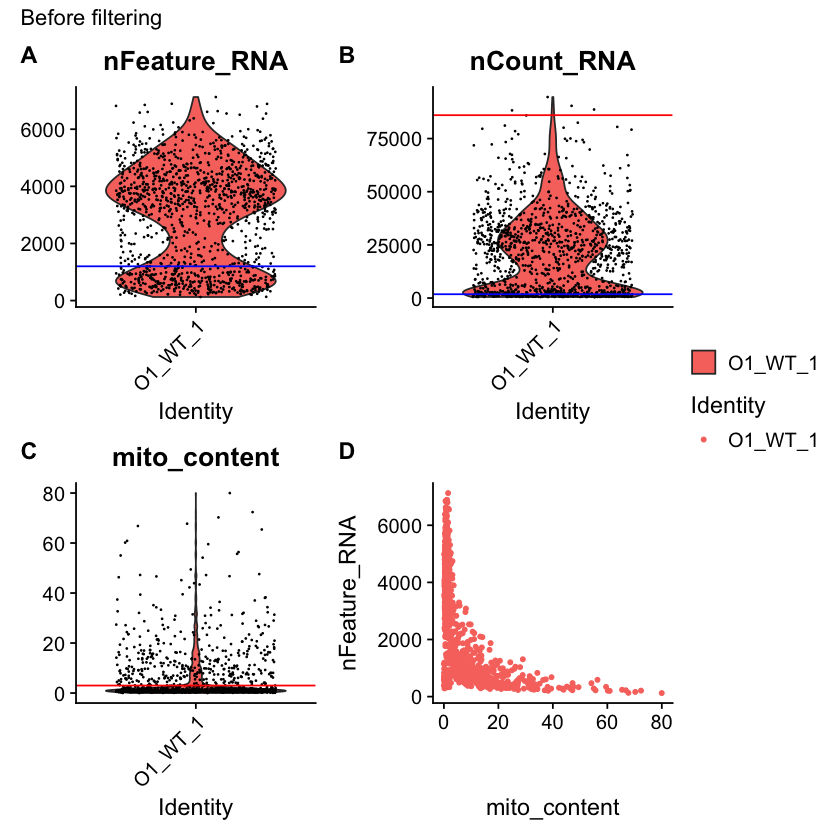

In [4]:
p1 <- VlnPlot(d_01_WT_1, features = c("nFeature_RNA"), 
                ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
    geom_hline(yintercept =1200, col="blue")
p2 <- VlnPlot(d_01_WT_1, features = c("nCount_RNA"), 
                ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
    geom_hline(yintercept =1800, col="blue") &
    geom_hline(yintercept = 86000, col="red")
p3 <- VlnPlot(d_01_WT_1, features = c("mito_content"), 
                ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
    geom_hline(yintercept =3, col="red")
p4 <- FeatureScatter(d_01_WT_1, 
        feature1 = "mito_content", feature2 = "nFeature_RNA", 
        shuffle = TRUE, plot.cor = FALSE)


p1 + p2 + p3 + p4 + plot_layout(
    ncol = 2, guides = "collect") + plot_annotation(
        title = "Before filtering", 
        tag_levels = "A")


An object of class Seurat 
14754 features across 812 samples within 1 assay 
Active assay: RNA (14754 features, 0 variable features)


Warning message:
“Removed 1 rows containing missing values (geom_hline).”
Warning message:
“Removed 1 rows containing missing values (geom_hline).”
Warning message:
“Removed 1 rows containing missing values (geom_hline).”
Warning message:
“Removed 1 rows containing missing values (geom_hline).”


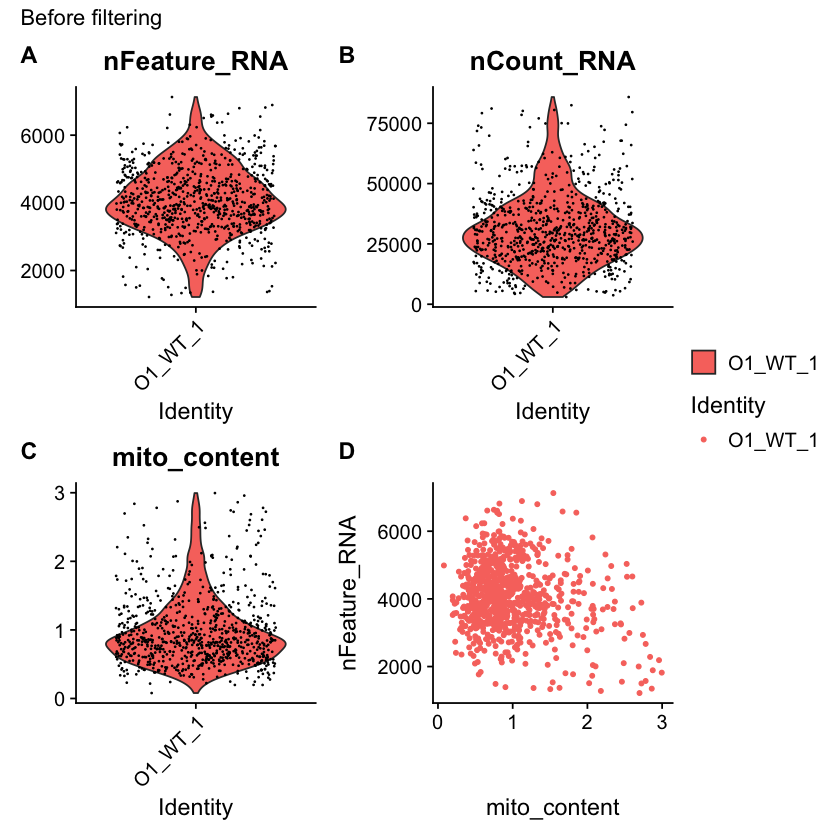

In [5]:
d_01_WT_1 <- subset(d_01_WT_1,
    subset = nFeature_RNA>1200 &
        nCount_RNA<86000 & nCount_RNA>1800 &
        mito_content<3
)
print(d_01_WT_1)


p1 <- VlnPlot(d_01_WT_1, features = c("nFeature_RNA"), 
                ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
    geom_hline(yintercept =1200, col="blue")
p2 <- VlnPlot(d_01_WT_1, features = c("nCount_RNA"), 
                ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
    geom_hline(yintercept =1800, col="blue") &
    geom_hline(yintercept = 86000, col="red")
p3 <- VlnPlot(d_01_WT_1, features = c("mito_content"), 
                ncol = 1, assay = "RNA", group.by = "orig.ident", stack = FALSE) & 
    geom_hline(yintercept =3, col="red")
p4 <- FeatureScatter(d_01_WT_1, 
        feature1 = "mito_content", feature2 = "nFeature_RNA", 
        shuffle = TRUE, plot.cor = FALSE)

p1 + p2 + p3 + p4 + plot_layout(
    ncol = 2, guides = "collect") + plot_annotation(
        title = "Before filtering", 
        tag_levels = "A")


# Normalisation, scaling and feature selection

First SCT to normalise and regress out mitocondrial content

In [6]:
d_01_WT_1 <- SCTransform(d_01_WT_1,
    vars.to.regress = "mito_content",
    variable.features.n = 10000)
d_01_WT_1

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13947 by 812

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 812 cells



  |======================================================================| 100%


Found 69 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13947 genes



  |======================================================================| 100%


Computing corrected count matrix for 13947 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 8.057328 secs

Determine variable features

Place corrected count matrix in counts slot

Regressing out mito_content

Centering data matrix

Set default assay to SCT



An object of class Seurat 
28701 features across 812 samples within 2 assays 
Active assay: SCT (13947 features, 10000 variable features)
 1 other assay present: RNA

Add in custom cell cycle scores

In [7]:
cc_genes <- read_tsv("Data/CellCycle_geneSet.txt")
s.features  <- na.omit(cc_genes$s) %>% str_to_sentence()
g2m.features <- na.omit(cc_genes$g2m) %>% str_to_sentence()
g1.features <- na.omit(cc_genes$g1) %>% str_to_sentence()
g1s.features <- unique(c(s.features, g1.features))
g1s.features <- setdiff(g1s.features, g2m.features)

d_01_WT_1 <- CellCycleScoring(d_01_WT_1,
    s.features = g1s.features,
    g2m.features = g2m.features,
    assay="SCT", set.ident = TRUE)
d_01_WT_1$Phase <- recode(d_01_WT_1$Phase, 
    G1="Other",S="Cycling", G2M="Mitosis")

New names:
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
Rows: 248 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): s, g2m, g1
lgl (3): ...4, ...5, ...6

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“The following features are not present in the object: Ccdc150, Cpne8, Gm13547, Mlf1ip, Reep1, 1700009n14rik, 2700049a03rik, Adamts1, Amd2, Antxr1, Bc048507, Fam189b, Gata2, Gm12666, Gm45713, Gm49369, Pcdh7, Plcxd1, Taf9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: Ccdc88a, Cfd, Depdc1b, Fancd2, Fyn, Gas1, Gm10184, Gm28635, Lix1l, Nmb, Pif1, Rad51c, Usp13, not searching for symbol synonyms”


In [8]:
#Regress out the difference between S and G2M scores
d_01_WT_1$CCDiff <- d_01_WT_1$S.Score - d_01_WT_1$G2M.Score
d_01_WT_1 <- SCTransform(d_01_WT_1,
    new.assay.name = "SCT",
    vars.to.regress = c("mito_content","CCDiff"),
    variable.features.n = 10000)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13947 by 812

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 812 cells



  |======================================================================| 100%


Found 69 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13947 genes



  |======================================================================| 100%


Computing corrected count matrix for 13947 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 7.483988 secs

Determine variable features

Place corrected count matrix in counts slot

Regressing out mito_content, CCDiff

Centering data matrix

Set default assay to SCT



In [9]:
d_01_WT_1 <- NormalizeData(d_01_WT_1,
    assay="RNA",
    normalization.method = "LogNormalize",
    scale.factor = 10000)

In [10]:
d_01_WT_1

An object of class Seurat 
28701 features across 812 samples within 2 assays 
Active assay: SCT (13947 features, 10000 variable features)
 1 other assay present: RNA

# DR

In [11]:
d_01_WT_1 <- RunPCA(d_01_WT_1, assay="SCT", reduction.name = "pca")

phate_dr <- phateR::phate(
    d_01_WT_1@reductions$pca@cell.embeddings,
    knn = 5, decay = 40, t = "auto",
    knn.dist.method = "euclidean",
    mds.solver = "sgd", mds.method = "metric", mds.dist.method = "euclidean",
    n.jobs = 1, seed = 12)
d_01_WT_1[["phate"]] <- CreateDimReducObject(embeddings = phate_dr$embedding,
    key = "PHATE_", assay = "SCT")

PC_ 1 
Positive:  Ptma, Gpx2, Rps2, Rpl3, Hsp90ab1, Nme1, Hspe1, Rpl14, Npm1, Hspd1 
	   Eef1g, Rps8, Rps18, Ccnd1, C1qbp, Rps17, Nhp2, Rpl8, Ranbp1, Rps19 
	   Rpl13, Snrpg, Hmgn1, Rps27a, Rpl12, Rpl27a, Ppp1r14b, Ran, Snrpf, Rpl4 
Negative:  Rbp2, Prap1, Muc3, Apoa1, Cyp4f14, Cyp3a13, Clec2h, Sult1b1, Fabp2, Clca4b 
	   Crip1, 2610528A11Rik, Selenop, AA467197, Smim24, Ankrd37, Selenbp1, Insig1, Hpgd, St3gal4 
	   Sprr2a3, Sult1d1, Sis, Ptprr, Cda, Prxl2b, Mxd1, Ly6m, Tm4sf5, Tmigd1 
PC_ 2 
Positive:  Fabp2, Crip1, Apoa1, Rbp2, Gsta1, Sult1b1, Smim24, Mgat4c, Dgat1, Aldob 
	   Ucp2, Hpgd, Mgst2, Mdh2, Gna11, Glod5, Gsta4, Tmigd1, Lgals2, Ndufa4 
	   Cyp4f14, Plac8, Lap3, Svip, Mep1b, Mgst3, Fmo5, Prap1, Aldh1a1, Cyp2c55 
Negative:  Cldn4, Ero1l, Ndrg1, Ifrd1, Nupr1, Btg1, Il1rn, Hspa5, Atf3, Dusp1 
	   Sqstm1, Ppp1r15a, Ddit3, Lpin2, Pmaip1, Zfand5, Slc2a1, Areg, Jun, Basp1 
	   Hk2, Gfpt1, Asns, Grpel2, Krt23, Krtcap2, Hmox1, Eif4ebp1, Sprr1a, Klf6 
PC_ 3 
Positive:  Rps12, Rps24, Tm

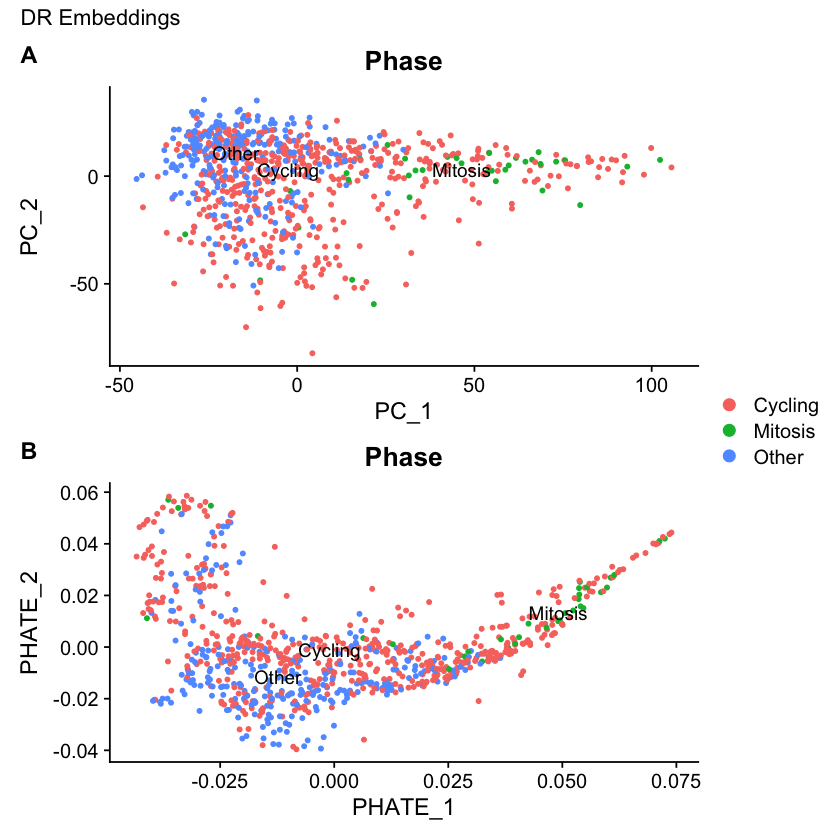

In [12]:
p1 <- DimPlot(d_01_WT_1, 
    reduction = "pca", group.by = "Phase", label = TRUE)
p2 <- DimPlot(d_01_WT_1,
    reduction = "phate", group.by = "Phase", label = TRUE)

p1 + p2 + plot_layout(
    ncol = 1, guides = "collect") + plot_annotation(
        title = "DR Embeddings", 
        tag_levels = "A")


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', 

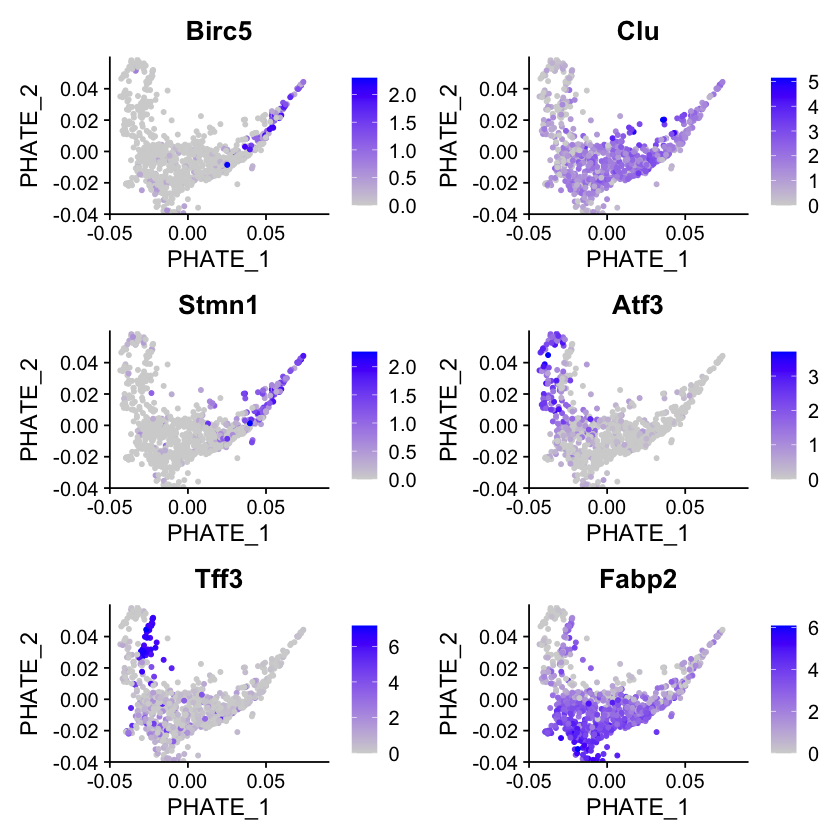

In [13]:
d_01_WT_1@active.assay <- "RNA"

FeaturePlot(d_01_WT_1, features = c("Birc5","Clu","Stmn1","Atf3","Tff3","Fabp2"), reduction = "phate") &
    scale_x_continuous(limits = c(-0.05,0.09), expand = c(0, 0)) &
    scale_y_continuous(limits = c(-0.04,0.06), expand = c(0, 0))

d_01_WT_1@active.assay <- "SCT"

# Clustering

In [14]:
d_01_WT_1 <- FindNeighbors(d_01_WT_1,
    reduction = "pca", dims = 1:48, assay = "SCT", 
    k.param = 20, prune.SNN = 1/15, n.trees = 50, annoy.metric = "euclidean", l2.norm = FALSE)

Computing nearest neighbor graph

Computing SNN



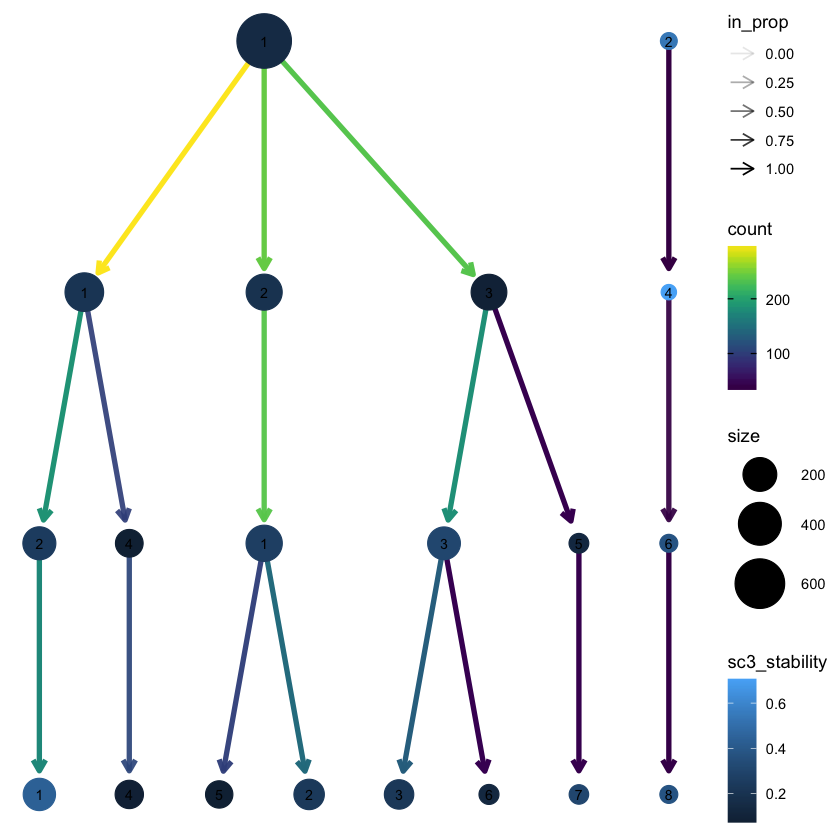

In [15]:
d_01_WT_1 <- FindClusters(d_01_WT_1,
    resolution = c(0.1,0.2,0.5,0.8),
    algorithm = 4, verbose = TRUE)
clustree(d_01_WT_1, prefix = "SCT_snn_res.", layout = c("sugiyama"), node_colour="sc3_stability")

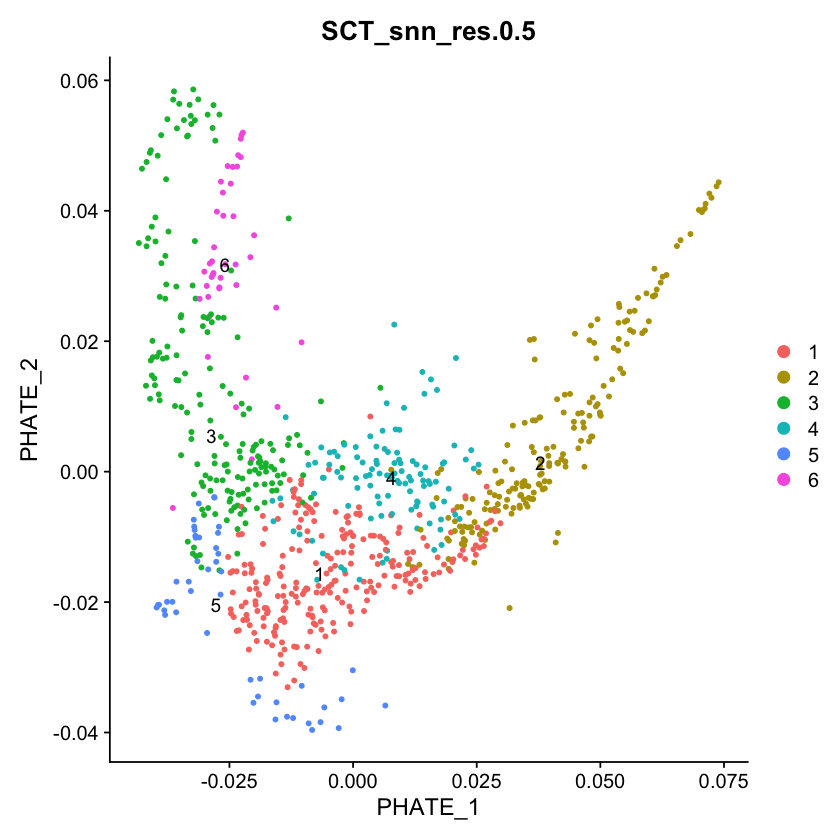

In [16]:
DimPlot(d_01_WT_1, reduction = "phate", group.by = "SCT_snn_res.0.5", label = TRUE)

# Interpretation

Have here a patchwork showing phate space with clusters on one side, and then vln plots for epi amrkers and a phate coloured by cycling status.

# Downstream analyses

For things like DE, entroyoy and velocity cehck the relevant notebooks
If we had more dataests we could integrate them like in XXX, and use DA to see which changes are induced in each condition, cellcomsn to see to how different cell types interact in a coculture,...